In [1]:
"""
    keras 转 estimator
    使用预定义的estimator
        BaselineClassifier
        LinearClassifier
        DNNClassifier
    Tf.feature_column 做特征工程
    
    
"""

'\n    keras 转 estimator\n    使用预定义的estimator\n        BaselineClassifier\n        LinearClassifier\n        DNNClassifier\n    Tf.feature_column 做特征工程\n    \n    \n'

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.0.0
sys.version_info(major=3, minor=6, micro=3, releaselevel='final', serial=0)
matplotlib 3.1.2
numpy 1.17.4
pandas 0.25.3
sklearn 0.21.3
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


In [4]:
train_file = "./data/titanic/train.csv"
eval_file = "./data/titanic/eval.csv"

train_df = pd.read_csv(train_file)
eval_df = pd.read_csv(eval_file)

y_train = train_df.pop("survived")
y_eval =  eval_df.pop("survived")

print(train_df.head(2))
print(eval_df.head(2))
print(y_train.head(2))
print(y_eval.head(2))


      sex   age  n_siblings_spouses  parch     fare  class     deck  \
0    male  22.0                   1      0   7.2500  Third  unknown   
1  female  38.0                   1      0  71.2833  First        C   

   embark_town alone  
0  Southampton     n  
1    Cherbourg     n  
    sex   age  n_siblings_spouses  parch     fare  class     deck  \
0  male  35.0                   0      0   8.0500  Third  unknown   
1  male  54.0                   0      0  51.8625  First        E   

   embark_town alone  
0  Southampton     y  
1  Southampton     y  
0    0
1    1
Name: survived, dtype: int64
0    0
1    0
Name: survived, dtype: int64


In [5]:
train_df.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [6]:
print(train_df.shape,eval_df.shape)

(627, 9) (264, 9)


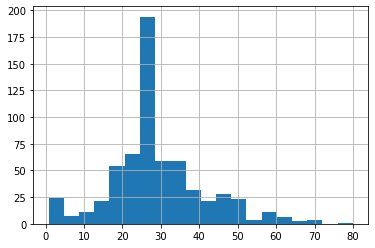

In [7]:
train_df.age.hist(bins = 20)

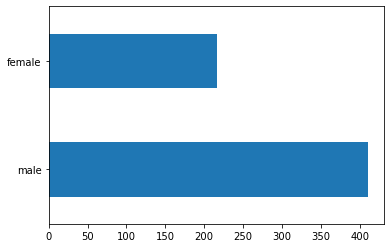

In [8]:
train_df.sex.value_counts().plot(kind ="barh" )

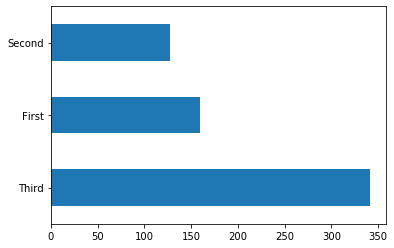

In [9]:
train_df["class"].value_counts().plot(kind ="barh" )

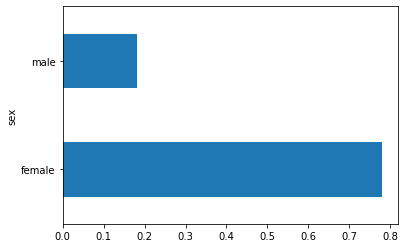

In [10]:
pd.concat([train_df,y_train],axis = 1).groupby("sex").survived.mean().plot(kind ="barh" )

In [14]:
# feature_column
categorical_columns = ["sex", "n_siblings_spouses", "parch", 
                       "class", "deck", "embark_town", "alone"]
numeric_columns = ["age","fare" ]
feature_columns = []
for categorical_column in categorical_columns:
    vocab = train_df[categorical_column].unique()
    # 离散特征作成one-hot编码
    onehot_describe = tf.feature_column.indicator_column(
        tf.feature_column.categorical_column_with_vocabulary_list(
            categorical_column, vocab))
    feature_columns.append(onehot_describe)
    
for numeric_column in numeric_columns:
    feature_columns.append(tf.feature_column.numeric_column(numeric_column, dtype = tf.float32))

sex ['male' 'female']
n_siblings_spouses [1 0 3 4 2 5 8]
parch [0 1 2 5 3 4]
class ['Third' 'First' 'Second']
deck ['unknown' 'C' 'G' 'A' 'B' 'D' 'F' 'E']
embark_town ['Southampton' 'Cherbourg' 'Queenstown' 'unknown']
alone ['n' 'y']


In [39]:
print(train_df)

        sex   age  n_siblings_spouses  parch     fare   class     deck  \
0      male  22.0                   1      0   7.2500   Third  unknown   
1    female  38.0                   1      0  71.2833   First        C   
2    female  26.0                   0      0   7.9250   Third  unknown   
3    female  35.0                   1      0  53.1000   First        C   
4      male  28.0                   0      0   8.4583   Third  unknown   
..      ...   ...                 ...    ...      ...     ...      ...   
622    male  28.0                   0      0  10.5000  Second  unknown   
623    male  25.0                   0      0   7.0500   Third  unknown   
624  female  19.0                   0      0  30.0000   First        B   
625  female  28.0                   1      2  23.4500   Third  unknown   
626    male  32.0                   0      0   7.7500   Third  unknown   

     embark_town alone  
0    Southampton     n  
1      Cherbourg     n  
2    Southampton     y  
3    Southa

In [33]:
def make_dataset(data_df, label_df, epochs = 10,# 数据集遍历多少次 ， 
                 shuffle = True, batch_size = 32):
    dataset = tf.data.Dataset.from_tensor_slices(
         (dict(data_df),label_df))
    if shuffle:
        dataset = dataset.shuffle(10000)
    dataset = dataset.repeat(epochs).batch(batch_size)
    return dataset

In [19]:
train_dataset = make_dataset(train_df, y_train, batch_size = 5)

In [23]:

for x,y in train_dataset.take(1):
    print(x,y)

{'sex': <tf.Tensor: id=89, shape=(5,), dtype=string, numpy=array([b'male', b'male', b'female', b'male', b'female'], dtype=object)>, 'age': <tf.Tensor: id=81, shape=(5,), dtype=float64, numpy=array([39., 36., 34., 19., 24.])>, 'n_siblings_spouses': <tf.Tensor: id=87, shape=(5,), dtype=int32, numpy=array([0, 1, 1, 0, 0])>, 'parch': <tf.Tensor: id=88, shape=(5,), dtype=int32, numpy=array([0, 2, 1, 0, 0])>, 'fare': <tf.Tensor: id=86, shape=(5,), dtype=float64, numpy=array([24.15  , 27.75  , 32.5   ,  8.05  , 83.1583])>, 'class': <tf.Tensor: id=83, shape=(5,), dtype=string, numpy=array([b'Third', b'Second', b'Second', b'Third', b'First'], dtype=object)>, 'deck': <tf.Tensor: id=84, shape=(5,), dtype=string, numpy=array([b'unknown', b'unknown', b'unknown', b'unknown', b'C'], dtype=object)>, 'embark_town': <tf.Tensor: id=85, shape=(5,), dtype=string, numpy=
array([b'Southampton', b'Southampton', b'Southampton', b'Southampton',
       b'Cherbourg'], dtype=object)>, 'alone': <tf.Tensor: id=82, s

In [26]:
# 将feature_column 应用到dataset上去
tf.keras.backend.set_floatx('float64')
for x,y in train_dataset.take(1):
    age_column = feature_columns[7]
    gender_column = feature_columns[0]
    print(keras.layers.DenseFeatures(age_column)(x).numpy())
    print(keras.layers.DenseFeatures(gender_column)(x).numpy())

[[28.]
 [28.]
 [25.]
 [28.]
 [28.]]
[[1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]]


In [27]:
tf.keras.backend.set_floatx('float64')
for x,y in train_dataset.take(1):
    age_column = feature_columns[7]
    gender_column = feature_columns[0]
    print(keras.layers.DenseFeatures(feature_columns)(x).numpy())

[[ 19.       0.       1.       0.       0.       1.       1.       0.
    0.       0.       0.       0.       0.       0.       1.       0.
    0.       0.      10.5      0.       1.       0.       0.       0.
    0.       0.       1.       0.       0.       0.       0.       0.
    1.       0.    ]
 [ 28.       1.       0.       1.       0.       0.       1.       0.
    0.       0.       0.       0.       0.       0.       0.       0.
    1.       0.       7.75     1.       0.       0.       0.       0.
    0.       0.       1.       0.       0.       0.       0.       0.
    1.       0.    ]
 [  2.       1.       0.       1.       0.       0.       1.       0.
    0.       0.       0.       0.       0.       0.       1.       0.
    0.       0.      21.075    0.       0.       1.       0.       0.
    0.       0.       0.       1.       0.       0.       0.       0.
    1.       0.    ]
 [ 23.       1.       0.       0.       1.       0.       0.       0.
    0.       0.       0.   

In [28]:
model = keras.models.Sequential([
    keras.layers.DenseFeatures(feature_columns),
    keras.layers.Dense(100,activation="relu"),
    keras.layers.Dense(100,activation="relu"),
    keras.layers.Dense(2,activation="softmax"),
])
model.compile(loss="sparse_categorical_crossentropy",
             optimizer = keras.optimizers.SGD(lr=0.01),
             metrics = ["accuracy"])


#### 运算
##### 1.model.fit
##### 2.model ->estimator -> train

In [37]:
# 1.model.fit

tf.keras.backend.set_floatx('float64')
train_dataset = make_dataset(train_df, y_train, epochs = 100)
eval_dataset = make_dataset(eval_df, y_eval,epochs = 1, shuffle= False)
history = model.fit(train_dataset,validation_data = eval_dataset,
                    steps_per_epoch = 20,
                    validation_steps =8,
                    epochs = 100
                   )


Train for 20 steps, validate for 8 steps
Epoch 1/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4798 - accuracy: 0.7719 - val_loss: 0.5212 - val_accuracy: 0.7422
Epoch 2/100
20/20 [==============================] - 0s 6ms/step - loss: 0.4773 - accuracy: 0.7703 - val_loss: 0.4865 - val_accuracy: 0.7461
Epoch 3/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4960 - accuracy: 0.7688 - val_loss: 0.5304 - val_accuracy: 0.7383
Epoch 4/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4636 - accuracy: 0.7828 - val_loss: 0.5245 - val_accuracy: 0.7305
Epoch 5/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4977 - accuracy: 0.7719 - val_loss: 0.4975 - val_accuracy: 0.7500
Epoch 6/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4839 - accuracy: 0.7922 - val_loss: 0.5529 - val_accuracy: 0.6875
Epoch 7/100
20/20 [==============================] - 0s 5ms/step - loss: 0.5015 - accuracy: 0.7703 - val_loss: 0.

ValueError: Empty training data.

In [38]:
# 2.model ->estimator -> train
estimator = keras.estimator.model_to_estimator(model)
# 1.function
# 2.return a.(features, label)
#          b.dataset => (feature, label)
estimator.train(input_fn = lambda: make_dataset(
                train_df, y_train, epochs=100
            ))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using the Keras model provided.
Note that this doesn't affect the state of the model instance you passed as `keras_model` argument.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\12399\\AppData\\Local\\Temp\\tmpq4564zi0', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001C976BC0B00>, '_task_type': 'worker', '_task_id': 0, '_globa

ValueError: Unexpectedly found an instance of type `<class 'dict'>`. Expected a symbolic tensor instance.